In [1]:
import numpy as np
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import h5py
import pickle
import constants as cst
from honeycomb import GetRecLatt
from LatticeInteraction import LattInter
import sys
import os
from mpl_toolkits.mplot3d import Axes3D
import Reading_Scripts as Reading
import Plotting_Scripts as Plotting
import Fourier_Transforms as Fourier
import Coulomb_Potentials as Potentials

np.set_printoptions(threshold=np.inf)

#%matplotlib notebook


    
def interp_new_orden(irvec,Vint_r,lat):
    
    
    
    Vint_r_trial=np.zeros((np.shape(Vint_r)[0],np.shape(Vint_r)[1],np.shape(Vint_r)[2]))
    
    
    for i_orb in range(0,np.shape(Vint_r)[0]):
        for j_orb in range(0,np.shape(Vint_r)[1]):
            
            
            xs = irvec[:,0] + (orbitales[i_orb,0] - orbitales[j_orb,0])
            ys = irvec[:,1] + (orbitales[i_orb,1] - orbitales[j_orb,1])
            zs = irvec[:,2] + (orbitales[i_orb,2] - orbitales[j_orb,2])
            a1, a2, a3 = lat[0,:], lat[1,:], lat[2,:]
            rvecs = xs[:,None] * a1[None,:] + ys[:,None] * a2[None,:]+ zs[:,None] * a3[None,:] 
            ds = np.sqrt(rvecs[:,0]**2 + rvecs[:,1]**2 + rvecs[:,2]**2)


            Ix = np.argsort(ds)
            
            
            datos=np.zeros((np.shape(ds)[0]))
            
            if i_orb==j_orb:
                popt, pcov = curve_fit(func, ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][1:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][1:])
                datos=func(ds[np.where(np.array(ds[Ix])!=0)[0]], *popt)
                datos=np.array(list(np.array([Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][0] ]))+list(datos))
                
                Vint_r_trial[i_orb,j_orb,:]=datos
            
            if i_orb!=j_orb:
                
                popt, pcov = curve_fit(func, ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][:])
                #datos=func(ds[np.where(np.array(ds[Ix])!=0)[0]], *popt)
                datos=func(ds, *popt)
                if abs(Vint_r[i_orb,j_orb,Ix][0]-datos[Ix][1])>=0.01:
                    
                    datos[Ix][0]=Vint_r[i_orb,j_orb,Ix][0]
                    datos=np.array(list(np.array([Vint_r[i_orb,j_orb,Ix][0] ]))+list(datos[1:]))
                if abs(Vint_r[i_orb,j_orb,Ix][0]-datos[Ix][1])<0.01:
                    popt_hub, pcov_hub = curve_fit(func_hub, ds[Ix][np.where(np.array(ds[Ix])<=20)[0]][:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=20)[0]][:])
                    datos_hub=func_hub(ds, *popt_hub)
                    datos_nuevo = datos_hub * rotation(2,ds,Ix) + datos * rotation(1,ds,Ix)
                    datos=np.array(list(datos_nuevo))
                #popt, pcov = curve_fit(func, ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][:])
                #datos=func(ds, *popt)
                #print(*popt)

                Vint_r_trial[i_orb,j_orb,:]=datos
        
    return Vint_r_trial


/home/juanpulgarin/anaconda3/lib/python3.9/site-packages/hankel/tools.py:14: RuntimeWarning: overflow encountered in sinh
  return t * np.tanh(np.pi * np.sinh(t) / 2)
/home/juanpulgarin/anaconda3/lib/python3.9/site-packages/hankel/tools.py:14: RuntimeWarning: overflow encountered in multiply
  return t * np.tanh(np.pi * np.sinh(t) / 2)


In [2]:
def GetCRPA(fname,number_points,new_points,filter_thresh=0.0):

    with open(fname, 'r') as f:
        lines = f.readlines()
        for i,line in enumerate(lines):
            if line.find("#nR      nwan") != -1:
                ili = i + 1

    s = lines[ili].split()
    nR = int(s[0])
    nwan = int(s[1])

    print("nR = ", nR)
    print("nwan = ", nwan)

    data = np.loadtxt(fname,skiprows=14)

    IRv = np.arange(0,nR)
    
    
    nx = number_points[0]
    ny = number_points[1]
    nz = number_points[2]
    
    first_x  = np.arange(0,int(nx/2)+1,1,dtype=int)
    second_x = np.arange(int(nx/2)+1,int(nx/2)+new_points[0]+1,1,dtype=int)
    third_x  = np.arange(-int(nx/2)+1-new_points[0],-int(nx/2)+1,1,dtype=int)
    forth_x  = np.arange(-int(nx/2)+1,0,1,dtype=int)
    
    first_y  = np.arange(0,int(ny/2)+1,1,dtype=int)
    second_y = np.arange(int(ny/2)+1,int(ny/2)+new_points[1]+1,1,dtype=int)
    third_y  = np.arange(-int(ny/2)+1-new_points[1],-int(ny/2)+1,1,dtype=int)
    forth_y  = np.arange(-int(ny/2)+1,0,1,dtype=int)
    
    first_z   = np.arange(0,int(nz/2)+1,1,dtype=int)
    second_z  = np.arange(int(nz/2)+1,int(nz/2)+new_points[2]+1,1,dtype=int)
    third_z   = np.arange(-int(nz/2)+1-new_points[2],-int(nz/2)+1,1,dtype=int)
    forth_z   = np.arange(-int(nz/2)+1,0,1,dtype=int)
    
    
    total_x = np.array( list(first_x) + list(second_x) + list(third_x) + list(forth_x) )
    total_y = np.array( list(first_y) + list(second_y) + list(third_y) + list(forth_y) )
    total_z = np.array( list(first_z) + list(second_z) + list(third_z) + list(forth_z) )

    
    irvec = np.zeros( (len(total_x)*len(total_y)*len(total_z),3),dtype=int )
    contador=0
    for kk in range(0,len(total_z)):
        for jj in range(0,len(total_y)):
            for ii in range(0,len(total_x)):
                
                irvec[contador,0] = total_x[ii]
                irvec[contador,1] = total_y[jj]
                irvec[contador,2] = total_z[kk]
                contador+=1
    
    
    
    Vint_r = np.zeros([nwan,nwan, nz+2*new_points[2],  ny+2*new_points[1],  nx+2*new_points[0]  ] )

    c_f_c=0
    
    dumb_array_1_x = np.arange( 0,int(nx/2)+1,1,dtype=int )
    dumb_array_2_x = np.arange( int(nx/2)+1+2*new_points[0],int(nx)+2*new_points[0],1,dtype=int )
    
    
    
    thearange_x    = np.array( list(dumb_array_1_x) + list(dumb_array_2_x) )
    natural_x      = np.arange( 0,int(nx),1,dtype=int )
    
    
    dumb_array_1_y = np.arange( 0,int(ny/2)+1,1,dtype=int )
    dumb_array_2_y = np.arange( int(ny/2)+1+2*new_points[1],int(ny)+2*new_points[1],1,dtype=int )
    
    
    thearange_y    = np.array( list(dumb_array_1_y) + list(dumb_array_2_y) )
    natural_y      = np.arange( 0,int(ny),1,dtype=int )

    dumb_array_1_z = np.arange( 0,int(nz/2)+1,1,dtype=int )
    dumb_array_2_z = np.arange( int(nz/2)+1+2*new_points[2],int(nz)+2*new_points[2],1,dtype=int )
    
    thearange_z    = np.array( list(dumb_array_1_z) + list(dumb_array_2_z) )
    natural_z      = np.arange(0,int(nz),1,dtype=int)

    del dumb_array_1_x; del dumb_array_2_x
    del dumb_array_1_y; del dumb_array_2_y
    del dumb_array_1_z; del dumb_array_2_z
    
    for iRz_n,iRz_o in zip(thearange_z,natural_z):
        for iRy_n,iRy_o in zip(thearange_y,natural_y):
            for iRx_n,iRx_o in zip(thearange_x,natural_x):  
            
                x = data[nwan*nwan*c_f_c:nwan*nwan*c_f_c+nwan*nwan,7]
                c_f_c+=1
                #Vint_r[:,:,iRx_n,iRy_n,iRz_n] = np.reshape(x, [nwan,nwan]) / cst.Ry
                Vint_r[:,:,iRz_n,iRy_n,iRx_n] = np.reshape(x, [nwan,nwan]) / cst.Ry
            
    Vint_r_nuevo = np.reshape(Vint_r,(nwan,nwan,(int(nx)+2*new_points[0])*(int(ny)+2*new_points[1])*(int(nz)+2*new_points[2]) ))
    
    
    if filter_thresh > 0.0:
        for i in range(nwan):
            for j in range(nwan):
                
                x = Vint_r_nuevo[i,j,:]
                Vint_r_nuevo[i,j,:] = Filter(filter_thresh, x)
    
    return irvec, Vint_r_nuevo



def Filter(rc,x):
    a = 2 / rc
    b = (1 - a*rc) / rc**2

    y = np.zeros_like(x)
    Ix1, = np.where((x > 0.) & (x < rc))
    y[Ix1] = a*x[Ix1]**2 + b*x[Ix1]**3
    Ix2, = np.where(x >= rc)
    y[Ix2] = x[Ix2]

    return y



def interp_new_orden(irvec,Vint_r,lat):
    
    
    
    Vint_r_trial=np.zeros((np.shape(Vint_r)[0],np.shape(Vint_r)[1],np.shape(Vint_r)[2]))
    
    
    for i_orb in range(0,np.shape(Vint_r)[0]):
        for j_orb in range(0,np.shape(Vint_r)[1]):
            
            
            xs = irvec[:,0] + (orbitales[i_orb,0] - orbitales[j_orb,0])
            ys = irvec[:,1] + (orbitales[i_orb,1] - orbitales[j_orb,1])
            zs = irvec[:,2] + (orbitales[i_orb,2] - orbitales[j_orb,2])
            
            a1, a2, a3 = lat[0,:], lat[1,:], lat[2,:]
            
            rvecs = xs[:,None] * a1[None,:] + ys[:,None] * a2[None,:]+ zs[:,None] * a3[None,:] 
            ds = np.sqrt(rvecs[:,0]**2 + rvecs[:,1]**2 + rvecs[:,2]**2)


            Ix = np.argsort(ds)
            
            
            datos=np.zeros((np.shape(ds)[0]))
            
            if i_orb==j_orb:
                popt, pcov = curve_fit(func, ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][1:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][1:])
                ##if i_orb== 0:
                ##    plt.plot(ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][1:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][1:])
                    
                datos = func(ds[np.where(np.array(ds[Ix])!=0)[0]], *popt)
                datos = np.array(list(np.array([Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][0] ]))+list(datos))
                
                Vint_r_trial[i_orb,j_orb,:] = datos
            
            if i_orb!=j_orb:
                
                popt, pcov = curve_fit(func, ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][:])
                #datos=func(ds[np.where(np.array(ds[Ix])!=0)[0]], *popt)
                datos = func(ds, *popt)
                if abs(Vint_r[i_orb,j_orb,Ix][0]-datos[Ix][1])>=0.01:
                    
                    datos[Ix][0]=Vint_r[i_orb,j_orb,Ix][0]
                    datos=np.array(list(np.array([Vint_r[i_orb,j_orb,Ix][0] ]))+list(datos[1:]))
                if abs(Vint_r[i_orb,j_orb,Ix][0]-datos[Ix][1])<0.01:
                    popt_hub, pcov_hub = curve_fit(func_hub, ds[Ix][np.where(np.array(ds[Ix])<=20)[0]][:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=20)[0]][:])
                    datos_hub=func_hub(ds, *popt_hub)
                    datos_nuevo = datos_hub * rotation(2,ds,Ix) + datos * rotation(1,ds,Ix)
                    datos = np.array(list(datos_nuevo))
                #popt, pcov = curve_fit(func, ds[Ix][np.where(np.array(ds[Ix])<=35)[0]][:],Vint_r[i_orb,j_orb,Ix][np.where(np.array(ds[Ix])<=35)[0]][:])
                #datos=func(ds, *popt)
                #print(*popt)

                Vint_r_trial[i_orb,j_orb,:] = datos
        
    return Vint_r_trial

def func(x, a,b,c):
    return a /(c*x+b) 

def func_hub(x, a,b):
    return a /(x+b)

def rotation(control,ds,Ix):
    if control==1:
        return (  np.arctan(1*(ds-ds[Ix][10]))  +np.pi/2)/np.max(np.arctan(1*(ds-ds[Ix][10])) +np.pi/2)
    if control==2:
        return (  np.arctan(-1*(ds-ds[Ix][10]))  +np.pi/2)/np.max(np.arctan(-1*(ds-ds[Ix][10])) +np.pi/2)

In [3]:
system="BlackP/"
path="./../../DATA/data_Screening/"
name_lat = path+system+'Lattice'
orbitales,parameters = Reading.ReadLattice(name_lat+'.h5')

file_crpa = path+system+"/cRPA_Uiijj.dat"

a = parameters[0] / cst.aB
b = parameters[1] / cst.aB
c = parameters[2] / cst.aB


lat = np.zeros([3,3])
lat[0,:] =  np.array([a,  0.0, 0.0])
lat[1,:] =  np.array([0.0,  b, 0.0])
lat[2,:] =  np.array([0.0, 0.0,  c])

## ----------------------------------------------------------------------------------------------------------------------------

nR =  1152
nwan =  32
nR =  1152
nwan =  32
U (real space) =  [0.28312752 0.29090586 0.23089752 0.28043862 0.28310021 0.29088159
 0.2312862  0.28054473 0.28312196 0.29090018 0.23098268 0.28046187
 0.28309029 0.29087328 0.23142016 0.28058169 0.28315653 0.29093121
 0.23074032 0.28035286 0.28313655 0.29091368 0.23102301 0.28043081
 0.28313943 0.2909172  0.23097852 0.28041909 0.28310444 0.2908861
 0.23147249 0.2805547 ]


/home/juanpulgarin/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


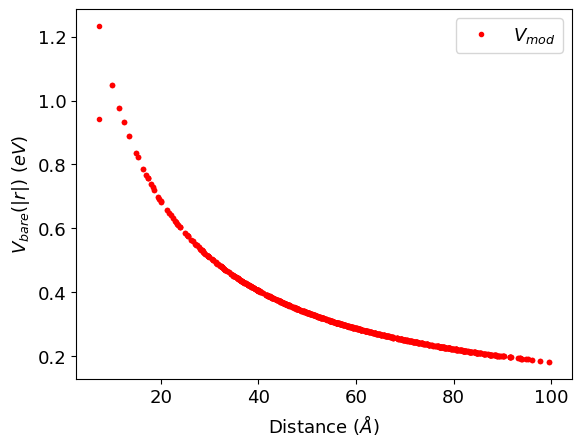

'\nfname = "data/"+system+"/Vbare_crpa_zero.h5"\n#fname = "data/"+system+"/Vbare_crpa.h5"\nVint.SaveToHDF5(fname)'

In [4]:
number_points = [12,12,8]
new_points    = [0,0,0]


irvec, Vint_r = GetCRPA(file_crpa,number_points,new_points, filter_thresh=0.001)

new_points1    = [4,4,4]


irvecE, Vint_rE = GetCRPA(file_crpa,number_points,new_points1, filter_thresh=0.001)



fname = path+system+"/Vcrpa_bare.p"
Reading.Export_lattspace(irvec,lat,Vint_r,fname)


Uhubb_r = np.array([ Vint_r[i,i,0] for i in range(Vint_r.shape[0]) ])
print("U (real space) = ", Uhubb_r)

nk1, nk2, nk3 = (number_points[0]+2*new_points[0]), (number_points[1]+2*new_points[1]), (number_points[2]+2*new_points[2])
Vint_q = Fourier.Transform_q(nk1,nk2,nk3,Vint_r)


#


"""Vint = Reading.ConstructInteraction(orbitales,irvec,Vint_r)
Plotting.PlotVintrold(irvec, Vint_r,orbitales, lat,10,0,"red","$V_{bare}$")

fname = "data/"+system+"/Vbare_crpa.h5"
#fname = "data/"+system+"/Vbare_crpa.h5"
Vint.SaveToHDF5(fname)

"""


v_nuevo_trial = interp_new_orden(irvec,Vint_r,lat)

v_nuevo_trialE = interp_new_orden(irvecE,Vint_rE,lat)

#v_nuevo_trial_zeros=np.zeros_like(v_nuevo_trial)

VintE = Reading.ConstructInteraction(orbitales,irvecE,v_nuevo_trialE)


Plotting.PlotVintrold(irvec, v_nuevo_trial,orbitales, lat,10,0,"red","$V_{mod}$")

#fname = "data/"+system+"/Vbare_crpa_extendido_plus+.h5"
#fname = "data/"+system+"/Vbare_crpa.h5"
#VintE.SaveToHDF5(fname)

#



"""
fname = "data/"+system+"/Vbare_crpa_zero.h5"
#fname = "data/"+system+"/Vbare_crpa.h5"
Vint.SaveToHDF5(fname)"""
#plt.plot(Vint_r[0,0,:])
#plt.plot(Vint_q[0,0,:])


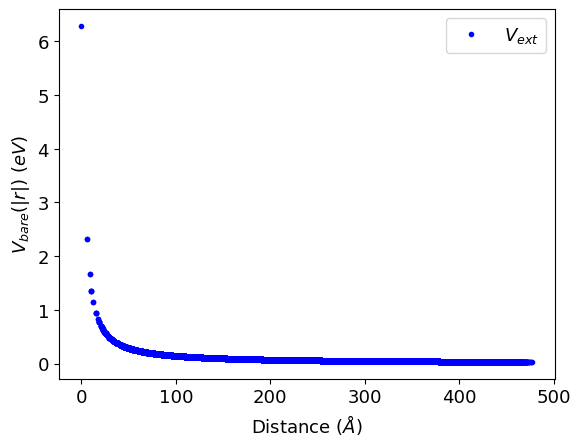

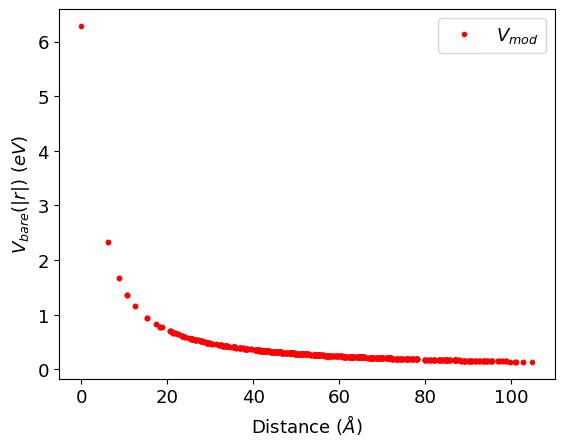

In [8]:
#fig, ax = plt.subplots()
Plotting.PlotVintrold(irvecE, v_nuevo_trialE,orbitales, lat,10,10,"blue","$V_{ext}$")
Plotting.PlotVintrold(irvec, v_nuevo_trial,orbitales, lat,10,10,"red","$V_{mod}$")
#plt.xlim(0,150)

In [5]:
irvec

array([[ 0,  0,  0],
       [ 1,  0,  0],
       [ 2,  0,  0],
       [ 3,  0,  0],
       [ 4,  0,  0],
       [ 5,  0,  0],
       [ 6,  0,  0],
       [-5,  0,  0],
       [-4,  0,  0],
       [-3,  0,  0],
       [-2,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 1,  1,  0],
       [ 2,  1,  0],
       [ 3,  1,  0],
       [ 4,  1,  0],
       [ 5,  1,  0],
       [ 6,  1,  0],
       [-5,  1,  0],
       [-4,  1,  0],
       [-3,  1,  0],
       [-2,  1,  0],
       [-1,  1,  0],
       [ 0,  2,  0],
       [ 1,  2,  0],
       [ 2,  2,  0],
       [ 3,  2,  0],
       [ 4,  2,  0],
       [ 5,  2,  0],
       [ 6,  2,  0],
       [-5,  2,  0],
       [-4,  2,  0],
       [-3,  2,  0],
       [-2,  2,  0],
       [-1,  2,  0],
       [ 0,  3,  0],
       [ 1,  3,  0],
       [ 2,  3,  0],
       [ 3,  3,  0],
       [ 4,  3,  0],
       [ 5,  3,  0],
       [ 6,  3,  0],
       [-5,  3,  0],
       [-4,  3,  0],
       [-3,  3,  0],
       [-2,  3,  0],
       [-1,  